<a href="https://colab.research.google.com/github/ivelin/donut_ui_refexp/blob/main/Fine_tune_Donut_on_UI_RefExp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fine-tune Donut 🍩 on UI RefExp

> _NOTE_: This notebook is based on the [Donut fine-tuning notebooks by Niels Rogge](https://github.com/NielsRogge/Transformers-Tutorials/tree/master/Donut). 

In this notebook, we'll fine-tune [Donut](https://huggingface.co/docs/transformers/model_doc/donut) (which is an instance of [`VisionEncoderDecoderModel`](https://huggingface.co/docs/transformers/model_doc/vision-encoder-decoder)) on a [UI RefExp dataset](https://huggingface.co/datasets/ivelin/ui_refexp_saved), which is a dataset consisting of triplets: (UI screenshot, prompt, and target bounding box). This way, the model will learn to look at a screenshot image, and answer a prompt referring to a UI component. For example: "select the search icon next to the menu drawer". This could be useful for tasks such as converting natural language app documentation to exectuable tests, bug reporting front end test automation and app support chat bots.

Multiple specialized models have been proposed to solve the UI RefExp task in recent years: [seq2act](https://paperswithcode.com/paper/mapping-natural-language-instructions-to), [UIBert](https://paperswithcode.com/paper/uibert-learning-generic-multimodal), [pix2struct](https://paperswithcode.com/paper/pix2struct-screenshot-parsing-as-pretraining) and others.

Here we will use Donut - a Document Understanding model with state of the art performance as of 2022. We will see Donut can be fine tuned to perform well on the UI RefExp task even though it was not originally designed for it. The intuition is that paper documents have similar visual and language comprehension challenges as UI screens. Since Donut is OCR-free multi-modal model, it should be able to pick up visual and text features in UI components as well as spacial relationships between them.

We will repurpose the DocVQA fine-tuning task so that the model learns to output bounding box coordinates of the referred component instead of its text label.

Let's get started!

## Set-up environment

First, let's install the relevant libraries:
* 🤗 Transformers, for the model
* 🤗 Datasets, for loading + processing the data
* PyTorch Lightning, for training the model
* Weights and Biases, for logging metrics during training
* Sentencepiece, used for tokenization.

In [1]:
!pip install -q git+https://github.com/huggingface/transformers.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
!pip install -q datasets sentencepiece

In [3]:
!pip install -q pytorch-lightning wandb

In [4]:
#@title Login to HuggingFace hub so we can save our trained model checkpoints
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To login, `huggingface_hub` now requires a token generated from https://huggingface.co/settings/tokens .
    
Token: 
Add token as git credential? (Y/n) n
Token is valid.
Your token has been saved to /root/.huggingface/token
Login successful


In [5]:
#@title Login to Weights&Biases so we can log and chart our training metrics
!wandb login

wandb: Currently logged in as: ivelin-eth. Use `wandb login --relogin` to force relogin


## Load dataset

Next, let's load the dataset from the [hub](https://huggingface.co/datasets/naver-clova-ix/cord-v2). We're prepared a minimal dataset for DocVQA, the notebook for that can be found [here](https://github.com/NielsRogge/Transformers-Tutorials/blob/master/Donut/DocVQA/Creating_a_toy_DocVQA_dataset_for_Donut.ipynb).

Important here is that we've added a "ground_truth" column, containing the ground truth JSON which the model will learn to generate.

In [6]:
REFEXP_DATASET_NAME = "ivelin/rico_refexp_combined"

# Pick which pretrained checkpoint to start the fine tuning process from
REFEXP_MODEL_CHECKPOINT = "ivelin/donut-refexp-combined-v1"

# REFEXP_MODEL_CHECKPOINT = "ivelin/donut-refexp-draft"
# REFEXP_MODEL_CHECKPOINT = "naver-clova-ix/donut-base"
# REFEXP_MODEL_CHECKPOINT = "ivelin/donut-docvqa-demo"


In [7]:
from datasets import load_dataset

dataset = load_dataset(REFEXP_DATASET_NAME)

  0%|          | 0/3 [00:00<?, ?it/s]

As can be seen, the dataset contains a training, a validation and a test split. And each example consists of an image, a prompt, and a target bounding box.

In [8]:
print(dataset['train'].info)
print(dataset)


DatasetInfo(description='', citation='', homepage='', license='', features={'image': Image(decode=True, id=None), 'image_id': Value(dtype='string', id=None), 'prompt': Value(dtype='string', id=None), 'target_bounding_box': {'xmax': Value(dtype='float64', id=None), 'xmin': Value(dtype='float64', id=None), 'ymax': Value(dtype='float64', id=None), 'ymin': Value(dtype='float64', id=None)}}, post_processed=None, supervised_keys=None, task_templates=None, builder_name=None, config_name=None, version=None, splits={'validation': SplitInfo(name='validation', num_bytes=409057163, num_examples=3191, shard_lengths=None, dataset_name='parquet'), 'test': SplitInfo(name='test', num_bytes=456367852, num_examples=3912, shard_lengths=None, dataset_name='parquet'), 'train': SplitInfo(name='train', num_bytes=42129003316, num_examples=390084, shard_lengths=[4590, 4590, 4590, 4590, 9180, 9180, 4590, 9180, 9180, 9180, 4590, 9180, 4590, 9178, 9178, 9178, 9178, 9178, 9178, 4589, 9178, 4589, 4589, 4589, 9178, 9

image width, height: (540, 960)
prompt: go to next
target bounding box: {'xmax': 1.0, 'xmin': 0.8759258985519409, 'ymax': 0.1041666641831398, 'ymin': 0.03854166716337204}
to image pixel values: xmin, ymin, xmax, ymax: (472, 37, 540, 99)


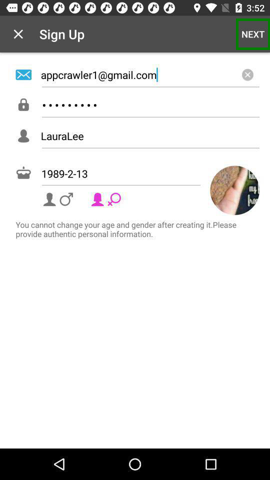

In [9]:
#@title Let's look at a sample in the dataset
import math
import json
from PIL import Image, ImageDraw

# change this index from 0 to split size to see different samples
sample = dataset['train'][49]
image = sample['image']
width, height = image.size
print(f"image width, height: {width, height}")
print(f"prompt: {sample['prompt']}")

# bb = json.loads(sample["target_bounding_box"])
bb = sample["target_bounding_box"]


print(f"target bounding box: {bb}")

xmin = math.floor(width*bb["xmin"])
ymin = math.floor(height*bb["ymin"])
xmax = math.floor(width*bb["xmax"])
ymax = math.floor(height*bb["ymax"])

print(f"to image pixel values: xmin, ymin, xmax, ymax: {xmin, ymin, xmax, ymax}")

shape = [(xmin, ymin), (xmax, ymax)]

# create rectangle image
img1 = ImageDraw.Draw(image)  
img1.rectangle(shape, outline ="green", width=5)
image.resize((int(width*0.5), int(height*0.5)))


## Load model and processor

Next, we load the model (which is an instance of [VisionEncoderDecoderModel](https://huggingface.co/docs/transformers/model_doc/vision-encoder-decoder), and the processor, which is the object that can be used to prepare inputs for the model.

In [10]:
from transformers import VisionEncoderDecoderConfig

pretrained_repo_name = REFEXP_MODEL_CHECKPOINT

max_length = 128
image_size = [1280, 960]

# update image_size of the encoder
# during pre-training, a larger image size was used
config = VisionEncoderDecoderConfig.from_pretrained(pretrained_repo_name)
config.encoder.image_size = image_size # (height, width)
# update max_length of the decoder (for generation)
config.decoder.max_length = max_length
# TODO we should actually update max_position_embeddings and interpolate the pre-trained ones:
# https://github.com/clovaai/donut/blob/0acc65a85d140852b8d9928565f0f6b2d98dc088/donut/model.py#L602

In [11]:
from transformers import DonutProcessor, VisionEncoderDecoderModel, BartConfig

processor = DonutProcessor.from_pretrained(pretrained_repo_name)
model = VisionEncoderDecoderModel.from_pretrained(pretrained_repo_name, config=config)

## Add special tokens

For DocVQA, we add special tokens for \<yes> and \<no/>, to make sure that the model (actually the decoder) learns embedding vectors for those explicitly.

In [12]:
from typing import List

def add_tokens(list_of_tokens: List[str]):
    """
    Add tokens to tokenizer and resize the token embeddings
    """
    newly_added_num = processor.tokenizer.add_tokens(list_of_tokens)
    if newly_added_num > 0:
        model.decoder.resize_token_embeddings(len(processor.tokenizer))

In [13]:
# # TODO: Do we need this for UI RefExp? It came from the DocVQA code
# additional_tokens = ["<yes/>", "<no/>"]

# add_tokens(additional_tokens)

## Create PyTorch dataset

Here we create a regular PyTorch dataset.

The model doesn't directly take the (image, JSON) pairs as input and labels. Rather, we create `pixel_values`, `decoder_input_ids` and `labels`. These are all PyTorch tensors. The `pixel_values` are the input images (resized, padded and normalized), the `decoder_input_ids` are the decoder inputs, and the `labels` are the decoder targets.

The reason we create the `decoder_input_ids` explicitly here is because otherwise, the model would create them automatically based on the `labels` (by prepending the decoder start token ID, replacing -100 tokens by padding tokens). The reason for that is that we don't want the model to learn to generate the entire prompt, which includes the question. Rather, we only want it to learn to generate the answer. Hence, we'll set the labels of the prompt tokens to -100.



In [14]:
import json
import random
from typing import Any, List, Tuple

import torch
from torch.utils.data import Dataset

added_tokens = []

class DonutDataset(Dataset):
    """
    DonutDataset which is saved in huggingface datasets format. (see details in https://huggingface.co/docs/datasets)
    Each row, consists of image blob, prompt and target bounding box.,
    and it will be converted into input_tensor(vectorized image) and input_ids(tokenized string).
    Args:
        dataset_name_or_path: name of dataset (available at huggingface.co/datasets) or the path containing image files and metadata.jsonl
        max_length: the max number of tokens for the target sequences
        split: whether to load "train", "validation" or "test" split
        ignore_id: ignore_index for torch.nn.CrossEntropyLoss
        task_start_token: the special token to be fed to the decoder to conduct the target task
        prompt_end_token: the special token at the end of the sequences
        sort_json_key: whether or not to sort the JSON keys
    """

    def __init__(
        self,
        dataset_name_or_path: str,
        max_length: int,
        range_samples: int = None,
        shuffle: bool = False,
        split: str = "train",
        ignore_id: int = -100,
        task_start_token: str = "<s>",
        prompt_end_token: str = None,
        sort_json_key: bool = True,
    ):
        super().__init__()

        self.max_length = max_length
        self.split = split
        self.ignore_id = ignore_id
        self.task_start_token = task_start_token
        self.prompt_end_token = prompt_end_token if prompt_end_token else task_start_token
        self.sort_json_key = sort_json_key

        self.dataset = load_dataset(dataset_name_or_path, split=self.split)

        self.gt_token_sequences = []
        if shuffle:
          self.dataset = self.dataset.shuffle()
        if range_samples is not None:
          self.dataset = self.dataset.select(range_samples)
        self.dataset = self.dataset.shuffle()
        self.dataset_length = self.dataset.num_rows
        for sample in self.dataset:
            prompt = sample["prompt"]
            # bb = json.loads(sample["target_bounding_box"])
            bb = sample["target_bounding_box"]
            # Trim float precision to simplify training with shorter string representations of component coordinates.
            # 2 decimals precision seems to be a good balance between component position acccuracy and model convergance time.
            # 3 decimals precision is good enough for screenshot size up to [1000x1000], but it takes longer for the model to converge.
            # For even finer granurality, we cam increase precision to 4 for [10,000 x 10,000] screen sizes, but it will take much more training time and compute resources to converge.
            for key, value in bb.items():
              bb[key] = round(value,2)

            assert isinstance(bb, dict)
            ground_truth = {"prompt": prompt, "target_bounding_box": bb}
            gt_json = ground_truth

            j2t = self.json2token(
                  gt_json,
                  update_special_tokens_for_json_key=self.split == "train",
                  sort_json_key=self.sort_json_key,
              ) + processor.tokenizer.eos_token
            self.gt_token_sequences.append(j2t)

        self.add_tokens([self.task_start_token, self.prompt_end_token])
        self.prompt_end_token_id = processor.tokenizer.convert_tokens_to_ids(self.prompt_end_token)

    def json2token(self, obj: Any, update_special_tokens_for_json_key: bool = True, sort_json_key: bool = True):
        """
        Convert an ordered JSON object into a token sequence
        """
        if type(obj) == dict:
            if len(obj) == 1 and "text_sequence" in obj:
                return obj["text_sequence"]
            else:
                output = ""
                if sort_json_key:
                    keys = sorted(obj.keys(), reverse=True)
                else:
                    keys = obj.keys()
                for k in keys:
                    if update_special_tokens_for_json_key:
                        self.add_tokens([fr"<s_{k}>", fr"</s_{k}>"])
                    output += (
                        fr"<s_{k}>"
                        + self.json2token(obj[k], update_special_tokens_for_json_key, sort_json_key)
                        + fr"</s_{k}>"
                    )
                return output
        elif type(obj) == list:
            return r"<sep/>".join(
                [self.json2token(item, update_special_tokens_for_json_key, sort_json_key) for item in obj]
            )
        else:
            obj = str(obj)
            if f"<{obj}/>" in added_tokens:
                obj = f"<{obj}/>"  # for categorical special tokens
            return obj
    
    def add_tokens(self, list_of_tokens: List[str]):
        """
        Add special tokens to tokenizer and resize the token embeddings of the decoder
        """
        newly_added_num = processor.tokenizer.add_tokens(list_of_tokens)
        if newly_added_num > 0:
            model.decoder.resize_token_embeddings(len(processor.tokenizer))
            added_tokens.extend(list_of_tokens)
    
    def __len__(self) -> int:
        return self.dataset_length - 1

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        """
        Load image from image_path of given dataset_path and convert into input_tensor and labels
        Convert gt data into input_ids (tokenized string)
        Returns:
            input_tensor : preprocessed image
            input_ids : tokenized gt_data
            labels : masked labels (model doesn't need to predict prompt and pad token)
        """
        sample = self.dataset[idx]

        # input_tensor
        pixel_values = processor(sample["image"].convert("RGB"), random_padding=self.split == "train", return_tensors="pt").pixel_values
        input_tensor = pixel_values.squeeze()

        # input_ids
        processed_parse = self.gt_token_sequences[idx]
        input_ids = processor.tokenizer(
            processed_parse,
            add_special_tokens=False,
            max_length=self.max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt",
        )["input_ids"].squeeze(0)

        if idx % 100 == 0:
          print(f"sameple #{idx}, input_ids: {input_ids}")

        if self.split == "train":
            labels = input_ids.clone()
            labels[
                labels == processor.tokenizer.pad_token_id
            ] = self.ignore_id  # model doesn't need to predict pad token
            labels[
                : torch.nonzero(labels == self.prompt_end_token_id).sum() + 1
            ] = self.ignore_id  # model doesn't need to predict prompt (for VQA)
            return input_tensor, input_ids, labels
        else:
            prompt_end_index = torch.nonzero(
                input_ids == self.prompt_end_token_id
            ).sum()  # return prompt end index instead of target output labels
            return input_tensor, input_ids, prompt_end_index, processed_parse

In [15]:
dataset

DatasetDict({
    validation: Dataset({
        features: ['image', 'image_id', 'prompt', 'target_bounding_box'],
        num_rows: 3191
    })
    test: Dataset({
        features: ['image', 'image_id', 'prompt', 'target_bounding_box'],
        num_rows: 3912
    })
    train: Dataset({
        features: ['image', 'image_id', 'prompt', 'target_bounding_box'],
        num_rows: 390084
    })
})

In [16]:
# we update some settings which differ from pretraining; namely the size of the images + no rotation required
# source: https://github.com/clovaai/donut/blob/master/config/train_cord.yaml
processor.feature_extractor.size = image_size[::-1] # should be (width, height)
processor.feature_extractor.do_align_long_axis = False

# For warm up phase, consider picking only a small subset to see if the model converges on the data
max_train_samples = 15000
# pick a range for sampling
# range_train_samples = range(4000, 4000+max_train_samples)
range_train_samples = range(max_train_samples)

train_dataset = DonutDataset(REFEXP_DATASET_NAME, max_length=max_length, 
                             range_samples=range_train_samples,
                             shuffle=True,
                             split="train", task_start_token="<s_refexp>", prompt_end_token="<s_target_bounding_box>",
                             sort_json_key=False,
                             )



/usr/local/lib/python3.8/dist-packages/transformers/models/donut/processing_donut.py:186: FutureWarning: `feature_extractor` is deprecated and will be removed in v5. Use `image_processor` instead.
  warnings.warn(


In [17]:
train_dataset[0]



sameple #0, input_ids: tensor([57527, 18539, 56738, 48941, 45125, 34445, 57528, 57529, 57535, 50891,
        39539, 15524, 57536, 57531, 50891, 39539, 20779, 57532, 57537, 50891,
        39539,  7505, 57538, 57533, 50891, 39539, 53979, 57534, 57530,     2,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1

(tensor([[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]],
 
         [[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]],
 
         [[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]]),
 tensor([57527, 18539, 56738, 48941, 45125, 34445, 57528, 57529, 57535, 50891,
   

In [18]:

# pick a small subset for initial val set to see if validation metrics improve
max_val_samples = 800
range_val_samples = range(max_val_samples)

val_dataset = DonutDataset(REFEXP_DATASET_NAME, max_length=max_length, range_samples=range_val_samples,
                             split="validation", task_start_token="<s_refexp>", prompt_end_token="<s_target_bounding_box>",
                             sort_json_key=False,
                             )


In [19]:
pixel_values, decoder_input_ids, labels = train_dataset[0]


sameple #0, input_ids: tensor([57527, 18539, 56738, 48941, 45125, 34445, 57528, 57529, 57535, 50891,
        39539, 15524, 57536, 57531, 50891, 39539, 20779, 57532, 57537, 50891,
        39539,  7505, 57538, 57533, 50891, 39539, 53979, 57534, 57530,     2,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1

In [20]:
pixel_values.shape

torch.Size([3, 1280, 960])

In [21]:
print(labels)

tensor([ -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100, 57535, 50891,
        39539, 15524, 57536, 57531, 50891, 39539, 20779, 57532, 57537, 50891,
        39539,  7505, 57538, 57533, 50891, 39539, 53979, 57534, 57530,     2,
         -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
         -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
         -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
         -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
         -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
         -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
         -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
         -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
         -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
         -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100])

In [22]:
for decoder_input_id, label in zip(decoder_input_ids.tolist()[:-1], labels.tolist()[1:]):
  if label != -100:
    print(processor.decode([decoder_input_id]), processor.decode([label]))
  else:
    print(processor.decode([decoder_input_id]), label)

<s_prompt> -100
click -100
on -100
the -100
lock -100
symbol -100
</s_prompt> -100
<s_target_bounding_box> <s_xmax>
<s_xmax> 0
0 .
. 98
98 </s_xmax>
</s_xmax> <s_xmin>
<s_xmin> 0
0 .
. 87
87 </s_xmin>
</s_xmin> <s_ymax>
<s_ymax> 0
0 .
. 42
42 </s_ymax>
</s_ymax> <s_ymin>
<s_ymin> 0
0 .
. 36
36 </s_ymin>
</s_ymin> </s_target_bounding_box>
</s_target_bounding_box> </s>
</s> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad

In [23]:
pixel_values, decoder_input_ids, prompt_end_index, processed_parse = val_dataset[0]


sameple #0, input_ids: tensor([57527, 18539, 48941, 37612, 48023, 57528, 57529, 57535, 50891, 39539,
        15524, 57536, 57531, 54824, 35934, 57532, 57537, 50891, 39539, 55654,
        57538, 57533, 50891, 39539, 55785, 57534, 57530,     2,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1

In [24]:
pixel_values.shape

torch.Size([3, 1280, 960])

In [25]:
prompt_end_index

tensor(6)

In [26]:
processed_parse

'<s_prompt>click the activate</s_prompt><s_target_bounding_box><s_xmax>0.98</s_xmax><s_xmin>0.02</s_xmin><s_ymax>0.46</s_ymax><s_ymin>0.39</s_ymin></s_target_bounding_box></s>'

## Create PyTorch DataLoaders

Next, we create corresponding PyTorch DataLoaders.

In [27]:
print(f"train dataset length: {train_dataset.dataset_length}")
print(f"validation dataset length: {val_dataset.dataset_length}")


train dataset length: 15000
validation dataset length: 800


In [28]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=4)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Let's verify a batch:

In [29]:
batch = next(iter(train_dataloader))
pixel_values, decoder_input_ids, labels = batch
print(pixel_values.shape)

torch.Size([1, 3, 1280, 960])


In [30]:
decoder_input_ids.shape

torch.Size([1, 128])

We can clearly see that we have set the labels of all prompt tokens (which includes the prompt) to -100, to make sure the model doesn't learn to generate them. We only start to have labels starting from the \<s_target_bounding_box> decoder input token.

In [31]:
for decoder_input_id, label in zip(decoder_input_ids[0].tolist()[:-1][:50], labels[0].tolist()[1:][:50]):
  if label != -100:
    print(processor.decode([decoder_input_id]), processor.decode([label]))
  else:
    print(processor.decode([decoder_input_id]), label)

<s_prompt> -100
open -100
we -100
all -100
know -100
item -100
</s_prompt> -100
<s_target_bounding_box> <s_xmax>
<s_xmax> 1.0
1.0 </s_xmax>
</s_xmax> <s_xmin>
<s_xmin> 0.0
0.0 </s_xmin>
</s_xmin> <s_ymax>
<s_ymax> 0.5
0.5 </s_ymax>
</s_ymax> <s_ymin>
<s_ymin> 0
0 .
. 36
36 </s_ymin>
</s_ymin> </s_target_bounding_box>
</s_target_bounding_box> </s>
</s> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100


## Define LightningModule

We'll fine-tune the model using [PyTorch Lightning](https://www.pytorchlightning.ai/) here, but note that you can of course also just fine-tune with regular PyTorch, HuggingFace [Accelerate](https://github.com/huggingface/accelerate), the HuggingFace [Trainer](https://huggingface.co/docs/transformers/main_classes/trainer), etc.

PyTorch Lightning is pretty convenient to handle things like device placement, mixed precision and logging for you.

## Defining Evaluation Metric

DocVQA normally uses Edit Distance, but that is not the most natural choice for bounding box evaluation.

### Distance between rectangle centers

In the early stages of training, center distance is a useful coarse grained eval metric. It tells us how close the center of the predicted bounding box is from the center of the ground truth bounding box.

As the model improves, we can switch to a more fine grained eval metric such as IoU. See further below.


In [32]:
import math

def get_center_distance(bb1, bb2):
    """
    Calculate the distance between the centers of two bounding boxes.
    Best case, distance between centers of predicted and ground truth bounding boxes will be 0.
    Worst case,  distance will be the larges diagonal in the screen - sqrt(1,1).

    Parameters
    ----------
    bb1 : dict
        Keys: {'xmin', 'xmax', 'ymin', 'ymax'}
        The (xmin, ymin) position is at the top left corner,
        the (xmax, y2) position is at the bottom right corner
    bb2 : dict
        Keys: {'xmin', 'xmax', 'ymin', 'ymax'}
        The (x, y) position is at the top left corner,
        the (xmax, ymax) position is at the bottom right corner

    Returns
    -------
    float
        in [0, sqrt(1+1)]
    """
    best_case = 0.0
    worst_case = math.sqrt(1+1) # max diagonal
    # print(f"IoU input bb1, bb2: {bb1} , {bb2}")
    # if predictions are not resulting in properly shaped bounding boxes, return no-match
    try:
      if bb1['xmin'] > bb1['xmax']:
        return worst_case # max distance = sqrt(1+1)
      if bb1['ymin'] > bb1['ymax']:
        return worst_case # max distance
      # if any of the bounding box labels are not properly shaped, return no-match
      if bb2['xmin'] > bb2['xmax']:
        return worst_case  # max distance
      if bb2['ymin'] > bb2['ymax']:
        return worst_case  # max distance
    except Exception as e:
      print(f"Error evaluating center distance between {bb1} and {bb2}", e)
      return worst_case      

    # determine the coordinates of the center of each rectangle
    bb1_x_center = (bb1['xmax'] + bb1['xmin'])/2
    bb1_y_center = (bb1['ymax'] + bb1['ymin'])/2

    bb2_x_center = (bb2['xmax'] + bb2['xmin'])/2
    bb2_y_center = (bb2['ymax'] + bb2['ymin'])/2
    center_dist = math.sqrt((bb2_x_center - bb1_x_center)**2 + (bb2_y_center - bb1_y_center)**2)

    assert center_dist >= best_case
    assert center_dist <= worst_case # sqrt(1+1)
    return center_dist


### Intersection over Union

We can use [Intersection over Union](https://pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/) (IoU) to measure bounding box match as a validation progress metric instead of the Edit Distance metric used in DocVQA.

Since the model outputs bounding box coordinates, we would like to see these bounding boxes trend towards overlapping exactly with the ground truth.

![IoU image](https://i.stack.imgur.com/n1AZj.png)

Edit distance also trends towards full match, but it may show less useful intermediate values. For example `xmin=0.123` and `xmin=0.923` are only 1 character separated, but in terms of bounding box overlap, they are very far apart.


In [33]:

def get_iou(bb1, bb2):
    """
    Calculate the Intersection over Union (IoU) of two bounding boxes.
    Best case, IoU is 1 indicating perfect match between prediction and ground truth.
    Worst case, IoU is 0 when no overlap between bounding boxes.
    Modifed version from the following original on stackoverflow:
    https://stackoverflow.com/questions/25349178/calculating-percentage-of-bounding-box-overlap-for-image-detector-evaluation

    Parameters
    ----------
    bb1 : dict
        Keys: {'xmin', 'xmax', 'ymin', 'ymax'}
        The (xmin, ymin) position is at the top left corner,
        the (xmax, y2) position is at the bottom right corner
    bb2 : dict
        Keys: {'xmin', 'xmax', 'ymin', 'ymax'}
        The (x, y) position is at the top left corner,
        the (xmax, ymax) position is at the bottom right corner

    Returns
    -------
    float
        in [0, 1]
    """
    best_case = 1.0
    worst_case = 0.0
    # print(f"IoU input bb1, bb2: {bb1} , {bb2}")
    # if predictions are not resulting in properly shaped bounding boxes, return no-match
    try:
      if bb1['xmin'] >= bb1['xmax']:
        return worst_case
      if bb1['ymin'] >= bb1['ymax']:
        return worst_case

      # if any of the bounding box labels are not properly shaped, return no-match
      if bb2['xmin'] >= bb2['xmax']:
        return worst_case
      if bb2['ymin'] >= bb2['ymax']:
        return worst_case
    except Exception as e:
      print(f"Error evaluating IoU between {bb1} and {bb2}", e)
      return worst_case

    # determine the coordinates of the intersection rectangle
    x_left = max(bb1['xmin'], bb2['xmin'])
    y_top = max(bb1['ymin'], bb2['ymin'])
    x_right = min(bb1['xmax'], bb2['xmax'])
    y_bottom = min(bb1['ymax'], bb2['ymax'])

    # print(f"IoU x_left: {x_left}, y_top: {y_top}, x_right: {x_right}, y_bottom: {y_bottom}")

    if x_right < x_left or y_bottom < y_top:
        return worst_case # no bbox overlap

    # The intersection of two axis-aligned bounding boxes is always an
    # axis-aligned bounding box
    intersection_area = (x_right - x_left) * (y_bottom - y_top)
    # print(f"IoU intersection_area: {intersection_area}")

    # compute the area of both AABBs
    bb1_area = (bb1['xmax'] - bb1['xmin']) * (bb1['ymax'] - bb1['ymin'])
    bb2_area = (bb2['xmax'] - bb2['xmin']) * (bb2['ymax'] - bb2['ymin'])
    # print(f"IoU bb1_area: {bb1_area}")
    # print(f"IoU bb2_area: {bb2_area}")

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    # if iou > 0:
    #   print(f"IoU input bb1, bb2: {bb1} , {bb2}")
    #   print(f"IoU : {iou}")
    assert iou >= worst_case
    assert iou <= best_case
    return iou

In [34]:
from pathlib import Path
import re
# from nltk import edit_distance
import numpy as np
import math

from torch.nn.utils.rnn import pad_sequence
from torch.optim.lr_scheduler import LambdaLR

import pytorch_lightning as pl
from pytorch_lightning.utilities import rank_zero_only


class DonutModelPLModule(pl.LightningModule):
    def __init__(self, config, processor, model):
        super().__init__()
        self.config = config
        self.processor = processor
        self.model = model

    def training_step(self, batch, batch_idx):
        pixel_values, decoder_input_ids, labels = batch
        
        outputs = self.model(pixel_values,
                             decoder_input_ids=decoder_input_ids[:, :-1],
                             labels=labels[:, 1:])
        loss = outputs.loss
        self.log_dict({"train_loss": loss}, sync_dist=True)
        return loss

    def token2bbox(self, seq: str):
        target_bbox = self.processor.token2json(seq)
        bbox = target_bbox.get('target_bounding_box')
        if bbox is None:
          print(f"token2bbox seq has no target_bounding_box, seq:{seq}")
          bbox = bbox = {"xmin": 0, "ymin": 0, "xmax": 0, "ymax": 0}
          return bbox
        # print(f"token2 bounding box json: {bbox}")
        # safeguard in case text prediction is missing some bounding box coordinates
        # or coordinates are not valid numeric values
        try:
          xmin = float(bbox.get("xmin", 0))
        except ValueError:
          xmin = 0
        try:
          ymin = float(bbox.get("ymin", 0))
        except ValueError:
          ymin = 0
        try:
          xmax = float(bbox.get("xmax", 1))
        except ValueError:
          xmax = 1
        try:
          ymax = float(bbox.get("ymax", 1))
        except ValueError:
          ymax = 1
        # replace str with float coords
        bbox = {"xmin": xmin, "ymin": ymin, "xmax": xmax, "ymax": ymax}
        # print(f"token2 bounding box float: {bbox}")
        return bbox

    def validation_step(self, batch, batch_idx, dataset_idx=0):
        pixel_values, decoder_input_ids, prompt_end_idxs, answers = batch
        decoder_prompts = pad_sequence(
            [input_id[: end_idx + 1] for input_id, end_idx in zip(decoder_input_ids, prompt_end_idxs)],
            batch_first=True,
        )
        
        outputs = self.model.generate(pixel_values,
                                   decoder_input_ids=decoder_prompts,
                                   max_length=max_length,
                                   early_stopping=True,
                                   pad_token_id=self.processor.tokenizer.pad_token_id,
                                   eos_token_id=self.processor.tokenizer.eos_token_id,
                                   use_cache=True,
                                   num_beams=1,
                                   bad_words_ids=[[self.processor.tokenizer.unk_token_id]],
                                   return_dict_in_generate=True,)
    
        predictions = []
        for seq in self.processor.tokenizer.batch_decode(outputs.sequences):
            seq = seq.replace(self.processor.tokenizer.eos_token, "").replace(self.processor.tokenizer.pad_token, "")
            seq = re.sub(r"<.*?>", "", seq, count=1).strip()  # remove first task start token
            predictions.append(seq)

        scores = list()
        for pred, answer in zip(predictions, answers):
            answer = re.sub(r"<.*?>", "", answer, count=1)
            answer = answer.replace(self.processor.tokenizer.eos_token, "")
            answer_bbox = self.token2bbox(answer)
            pred_bbox = self.token2bbox(pred)
            scores.append(get_center_distance(pred_bbox, answer_bbox))
            # scores.append(get_iou(pred_bbox, answer_bbox))
            if self.config.get("verbose", False) and len(scores) == 1:
              print(f"      Prediction: {pred}")
              print(f"          Answer: {answer}")
              print(f" Prediction bbox: {pred_bbox}")
              print(f"     Answer bbox: {answer_bbox}")
              print(f"Eval score (Center Distance): {scores[0]}")
              # print(f"Eval score (IoU): {scores[0]}")
              # print(f"Eval score (Edit Distance): {scores[2]}")

        return scores

    def validation_epoch_end(self, validation_step_outputs):
        # I set this to 1 manually
        # (previously set to len(self.config.dataset_name_or_paths))
        num_of_loaders = 1
        if num_of_loaders == 1:
            validation_step_outputs = [validation_step_outputs]
        assert len(validation_step_outputs) == num_of_loaders
        cnt = [0] * num_of_loaders
        total_metric = [0] * num_of_loaders
        val_metric = [0] * num_of_loaders
        for i, results in enumerate(validation_step_outputs):
            for scores in results:
                cnt[i] += len(scores)
                total_metric[i] += np.sum(scores)
            val_metric[i] = total_metric[i] / cnt[i]
            val_metric_name = f"val_metric_{i}th_dataset"
            self.log_dict({val_metric_name: val_metric[i]}, sync_dist=True)
        self.log_dict({"val_metric": np.sum(total_metric) / np.sum(cnt)}, sync_dist=True)

    def configure_optimizers(self):
        # TODO add scheduler
        optimizer = torch.optim.Adam(self.parameters(), lr=self.config.get("lr"))
    
        return optimizer

    def train_dataloader(self):
        return train_dataloader

    def val_dataloader(self):
        return val_dataloader

Next, we instantiate the module:

In [35]:
config = {"max_epochs": 2, # aim for 30,
          "val_check_interval":0.4, # how many times we want to validate during an epoch
          "check_val_every_n_epoch":1,
          "gradient_clip_val":1.0,
          "num_training_samples_per_epoch": 800,
          "lr":3e-6, # Start at 3e-5 and reduce gradually every few epochs if loss oscilations too high
          "train_batch_sizes": [8],
          "val_batch_sizes": [1],
          # "seed":2022,
          "num_nodes": 1,
          "warmup_steps": 20, # 20 = 800/8*2/10, 10%; 300 for 800/8*30/10, 10%
          "result_path": "./result",
          "verbose": True,
          }
 
model_module = DonutModelPLModule(config, processor, model)

## Train!

In [36]:
import wandb
# clear any previously open logging session
wandb.finish()

In [37]:
from pytorch_lightning.loggers import WandbLogger
 

wandb_logger = WandbLogger(project="Donut-RefExp")

trainer = pl.Trainer(
        accelerator="gpu",
        devices=1,
        max_epochs=config.get("max_epochs"),
        val_check_interval=config.get("val_check_interval"),
        check_val_every_n_epoch=config.get("check_val_every_n_epoch"),
        gradient_clip_val=config.get("gradient_clip_val"),
        precision=16, # we'll use mixed precision
        num_sanity_val_steps=0,
        logger=wandb_logger
        # callbacks=[lr_callback, checkpoint_callback],
)



wandb: Currently logged in as: ivelin-eth. Use `wandb login --relogin` to force relogin


INFO:pytorch_lightning.utilities.rank_zero:Using 16bit None Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(model_module) #, ckpt_path="last")

Validation: 0it [00:00, ?it/s]

sameple #0, input_ids: tensor([57527, 18539, 48941, 37612, 48023, 57528, 57529, 57535, 50891, 39539,
        15524, 57536, 57531, 54824, 35934, 57532, 57537, 50891, 39539, 55654,
        57538, 57533, 50891, 39539, 55785, 57534, 57530,     2,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1

# Push to hub and reuse

HuggingFace's [hub](https://huggingface.co/) is a nice place to host, version and share machine learning models (and datasets, and demos in the form of [Spaces](https://huggingface.co/spaces)).

We first provide our authentication token.

Pushing to the hub after training is as easy as:

In [ ]:
repo_name = "ivelin/donut-refexp-combined-v1"

#
# here we push the processor and model to the hub
# note that you can add `private=True` in case you're using the private hub
# which makes sure the model is only shared with your colleagues
model_module.processor.push_to_hub(repo_name) 
model_module.model.push_to_hub(repo_name)

 

Reloading can then be done as:

In [ ]:
from transformers import DonutProcessor, VisionEncoderDecoderModel

processor = DonutProcessor.from_pretrained(repo_name)
model = VisionEncoderDecoderModel.from_pretrained(repo_name)

backup_repo_name = "ivelin/donut-refexp-combined-v1-backup"

# save a backup in case uploading to the main model fails and corrupts the data
model_module.processor.push_to_hub(backup_repo_name) 
model_module.model.push_to_hub(backup_repo_name)


## Inference

For inference, you can use this [Gradio playground notebook](https://github.com/ivelin/donut_ui_refexp/blob/main/Donut_UI_RefExp_Gradio_Inference_Playground.ipynb) or this [Huggingface playspace](https://huggingface.co/spaces/ivelin/ui-refexp). Also see to the Donut [docs](https://huggingface.co/docs/transformers/main/en/model_doc/donut#inference).